# **SEATTLE CRIME ON THE DIME**
Adamou Tidjani, Gina Philipose, and Trinh Tran

*The project is about forecasting the location and number of crimes that occur in the neighborhoods of Seattle. We are using data from the Seattle Police Department (SPD) which contains 1.49 million rows and 19 columns. We have identified 13 columns of interest that will help us achieve our goal. Our objective is to create a model that we can hand off to the city to help them predict where a crime would have more likely occurred given the time and type of crime. For example, let’s say someone is a victim of a crime at a certain time and might not know where they are located, the police officers can use our model to best predict where they should intervene and possibly save that person’s life.*

# Data Acquistion and Pre-processing

## Import libraries & Read the data

In [ ]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact, widgets
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn import tree
import geopandas as gpd
from shapely.geometry import Point

In [ ]:
url = "https://huggingface.co/datasets/tnltrinh/seattle_crime/resolve/main/dataset/origional_ds.csv"
crime_data = pd.read_csv(
    url,
    na_values=['-', 'REDACTED','UNKNOWN', 'FK ERROR'],
    low_memory=False
)
crime_data.head()

,Report Number,Report DateTime,Offense ID,Offense Date,NIBRS Group AB,NIBRS Crime Against Category,Offense Sub Category,Shooting Type Group,Block Address,Latitude,Longitude,Beat,Precinct,Sector,Neighborhood,Reporting Area,Offense Category,NIBRS Offense Code Description,NIBRS_offense_code
0,2010-902213,2010 Dec 02 04:17:00 PM,7700230809,2010 Dec 02 02:00:00 PM,A,PROPERTY,LARCENY-THEFT,NaN,72XX BLOCK OF WOODLAWN AVE NE,47.680845,-122.324916,J3,North,J,NaN,8706,PROPERTY CRIME,Theft From Building,23D
1,2011-296913,2011 Sep 08 05:22:00 PM,7626066385,2011 Sep 08 12:00:00 AM,B,ANY,ALL OTHER,NaN,26TH AVE NE / NE 127TH ST,47.721120,-122.300489,L1,North,L,NaN,230,ALL OTHER,All Other Offenses,90Z
2,2015-294854,2015 Aug 23 08:29:00 PM,7690271814,2015 Aug 23 01:30:00 PM,A,PROPERTY,BURGLARY,NaN,9XX BLOCK OF N 72ND ST,47.681046,-122.345838,J3,North,J,NaN,1474,PROPERTY CRIME,Burglary/Breaking & Entering,220
3,2014-132453,2014 Apr 30 01:57:00 PM,7687185106,2014 Apr 30 01:10:00 PM,A,PROPERTY,LARCENY-THEFT,NaN,14XX BLOCK OF BROADWAY,47.613520,-122.320771,E2,East,E,NaN,4218,PROPERTY CRIME,Theft From Building,23D
4,2019-454354,2019 Dec 08 03:17:05 PM,12034644268,2019 Dec 07 08:00:00 PM,A,PROPERTY,MOTOR VEHICLE THEFT,NaN,29XX BLOCK OF 19TH AVE S,47.577424,-122.308014,R1,South,R,NORTH BEACON HILL,701,PROPERTY CRIME,Motor Vehicle Theft,240


## Get an overview of the dataset

In [ ]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484399 entries, 0 to 1484398
Data columns (total 19 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   Report Number                   1484399 non-null  object 
 1   Report DateTime                 1484399 non-null  object 
 2   Offense ID                      1484399 non-null  int64  
 3   Offense Date                    1484399 non-null  object 
 4   NIBRS Group AB                  1482797 non-null  object 
 5   NIBRS Crime Against Category    1482797 non-null  object 
 6   Offense Sub Category            1482797 non-null  object 
 7   Shooting Type Group             9566 non-null     object 
 8   Block Address                   1097311 non-null  object 
 9   Latitude                        1269803 non-null  float64
 10  Longitude                       1269803 non-null  float64
 11  Beat                            1473190 non-null  object 
 12  

In [ ]:
crime_data.isna().sum()

,0
Report Number,0
Report DateTime,0
Offense ID,0
Offense Date,0
NIBRS Group AB,1602
NIBRS Crime Against Category,1602
Offense Sub Category,1602
Shooting Type Group,1474833
Block Address,387088
Latitude,214596


In [ ]:
check_col = ['NIBRS Group AB', 'NIBRS Crime Against Category', 'Offense Sub Category', 'Offense Category', 'NIBRS Offense Code Description', 'Shooting Type Group']
print('Unique values of some columns: ')
for col in check_col:
    print(col + ': ' + str(crime_data[col].unique().tolist()))

Unique values of some columns: 
NIBRS Group AB: ['A', 'B', nan]
NIBRS Crime Against Category: ['PROPERTY', 'ANY', 'PERSON', 'SOCIETY', 'NOT_A_CRIME', nan]
Offense Sub Category: ['LARCENY-THEFT', 'ALL OTHER', 'BURGLARY', 'MOTOR VEHICLE THEFT', 'AGGRAVATED ASSAULT', 'ROBBERY', 'VIOLATION OF NO CONTACT ORDER', 'EXTORTION/FRAUD/FORGERY/BRIBERY (INCLUDES BAD CHECKS)', 'PROPERTY OFFENSES (INCLUDES STOLEN, DESTRUCTION)', 'DUI', 'KIDNAPPING/ABDUCTION', '999', 'ARSON', 'ASSAULT OFFENSES', 'TRESPASS', 'PROSTITUTION OFFENSES', 'NARCOTIC VIOLATIONS (INCLUDES DRUG EQUIP.)', 'NON-VIOLENT FAMILY OFFENSES', 'DISORDERLY CONDUCT & VAGRANCY VIOLATIONS', 'WEAPON LAW VIOLATION', 'RAPE', 'PORNOGRAPHY', 'SEX OFFENSES', nan, 'LIQUOR LAW VIOLATIONS & DRUNKENNESS', 'HOMICIDE', 'HUMAN TRAFFICKING', 'ANIMAL CRUELTY', 'JUSTIFIABLE HOMICIDE', 'GAMBLING OFFENSES', 'RUNAWAY']
Offense Category: ['PROPERTY CRIME', 'ALL OTHER', 'VIOLENT CRIME']
NIBRS Offense Code Description: ['Theft From Building', 'All Other Offenses'

## Transform & pre-processing data

Convert Report DateTime and Offense Date columns to datetime

In [ ]:
crime_data["Report DateTime"] = pd.to_datetime(
    crime_data["Report DateTime"], errors='coerce'
)
crime_data["Offense Date"] = pd.to_datetime(
    crime_data["Offense Date"], errors='coerce'
)

/tmp/ipython-input-1583285012.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crime_data["Report DateTime"] = pd.to_datetime(
/tmp/ipython-input-1583285012.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crime_data["Offense Date"] = pd.to_datetime(


In [ ]:
# Find columns where all values are unique
unique_columns = [col for col in crime_data.columns if crime_data[col].is_unique]
print("Columns with all unique values:")
print(unique_columns)

Columns with all unique values:
[]


Extract day, month, year to group by and visualize data easier

In [ ]:
crime_data["Report_Year"] = crime_data["Report DateTime"].dt.year
crime_data["Report_Month"] = crime_data["Report DateTime"].dt.month
crime_data["Report_Day"] = crime_data["Report DateTime"].dt.day

crime_data["Offense_Year"] = crime_data["Offense Date"].dt.year
crime_data["Offense_Month"] = crime_data["Offense Date"].dt.month
crime_data["Offense_Day"] = crime_data["Offense Date"].dt.day

Transform other columns datatype to correct datatypes:

In [ ]:
# Convert numeric object columns to int or float
crime_data['Offense ID'] = pd.to_numeric(crime_data['Offense ID'], errors='coerce').astype('Int64')

# Convert columns to string
string_columns = [
    'Report Number',
    'NIBRS Group AB',
    'NIBRS Crime Against Category',
    'Offense Sub Category',
    'Shooting Type Group',
    'Block Address',
    'Beat',
    'Precinct',
    'Sector',
    'Neighborhood',
    'Reporting Area',
    'Offense Category',
    'NIBRS Offense Code Description',
    'NIBRS_offense_code'
]

crime_data[string_columns] = crime_data[string_columns].astype('string')

# Convert coordinates to float
crime_data['Latitude'] = pd.to_numeric(crime_data['Latitude'], errors='coerce').astype('float')
crime_data['Longitude'] = pd.to_numeric(crime_data['Longitude'], errors='coerce').astype('float')

In [ ]:
crime_data.describe()

,Report DateTime,Offense ID,Offense Date,Latitude,Longitude,Report_Year,Report_Month,Report_Day,Offense_Year,Offense_Month,Offense_Day
count,1484399,1484399.0,1484399,1.269803e+06,1.269803e+06,1.484399e+06,1.484399e+06,1.484399e+06,1.484399e+06,1.484399e+06,1.484399e+06
mean,2016-11-28 07:17:04.905396992,18055346622.397987,2016-11-16 05:40:12.180709632,4.103985e+01,-1.058155e+02,2.016412e+03,6.481220e+00,1.579144e+01,2.016379e+03,6.483647e+00,1.565692e+01
min,1975-12-16 15:00:00,7624428906.0,1900-01-01 00:00:00,-1.000000e+00,-1.743130e+02,1.975000e+03,1.000000e+00,1.000000e+00,1.900000e+03,1.000000e+00,1.000000e+00
25%,2012-07-23 09:55:30,7658679966.5,2012-07-13 09:55:00,4.755837e+01,-1.223447e+02,2.012000e+03,4.000000e+00,8.000000e+00,2.012000e+03,4.000000e+00,8.000000e+00
50%,2017-01-12 16:57:00,7688696715.0,2017-01-02 20:22:00,4.761121e+01,-1.223252e+02,2.017000e+03,7.000000e+00,1.600000e+01,2.017000e+03,7.000000e+00,1.600000e+01
75%,2021-04-09 21:12:18.500000,22894245969.5,2021-03-29 10:00:00,4.765757e+01,-1.222984e+02,2.021000e+03,9.000000e+00,2.300000e+01,2.021000e+03,9.000000e+00,2.300000e+01
max,2025-09-28 23:52:05,66290060291.0,2025-09-28 21:19:00,8.999999e+01,1.755310e+02,2.025000e+03,1.200000e+01,3.100000e+01,2.025000e+03,1.200000e+01,3.100000e+01
std,NaN,17882998446.883492,NaN,1.668497e+01,4.166065e+01,5.087274e+00,3.399356e+00,8.813217e+00,5.111456e+00,3.402128e+00,8.854004e+00


Info after converting the datatype

In [ ]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484399 entries, 0 to 1484398
Data columns (total 25 columns):
 #   Column                          Non-Null Count    Dtype         
---  ------                          --------------    -----         
 0   Report Number                   1484399 non-null  string        
 1   Report DateTime                 1484399 non-null  datetime64[ns]
 2   Offense ID                      1484399 non-null  Int64         
 3   Offense Date                    1484399 non-null  datetime64[ns]
 4   NIBRS Group AB                  1482797 non-null  string        
 5   NIBRS Crime Against Category    1482797 non-null  string        
 6   Offense Sub Category            1482797 non-null  string        
 7   Shooting Type Group             9566 non-null     string        
 8   Block Address                   1097311 non-null  string        
 9   Latitude                        1269803 non-null  float64       
 10  Longitude                       1269803 no

Create an additional **duration** column which means the duration from the Report DateTime and Offense Date

In [ ]:
crime_data['Duration'] = crime_data['Report DateTime'] - crime_data['Offense Date']

# Move 'duration' right after 'Offense Date'
cols = list(crime_data.columns)
offense_index = cols.index('Offense Date')
cols.insert(offense_index + 1, cols.pop(cols.index('Duration')))
crime_data = crime_data[cols]

In [ ]:
crime_data.head()

,Report Number,Report DateTime,Offense ID,Offense Date,Duration,NIBRS Group AB,NIBRS Crime Against Category,Offense Sub Category,Shooting Type Group,Block Address,...,Reporting Area,Offense Category,NIBRS Offense Code Description,NIBRS_offense_code,Report_Year,Report_Month,Report_Day,Offense_Year,Offense_Month,Offense_Day
0,2010-902213,2010-12-02 16:17:00,7700230809,2010-12-02 14:00:00,0 days 02:17:00,A,PROPERTY,LARCENY-THEFT,<NA>,72XX BLOCK OF WOODLAWN AVE NE,...,8706,PROPERTY CRIME,Theft From Building,23D,2010,12,2,2010,12,2
1,2011-296913,2011-09-08 17:22:00,7626066385,2011-09-08 00:00:00,0 days 17:22:00,B,ANY,ALL OTHER,<NA>,26TH AVE NE / NE 127TH ST,...,230,ALL OTHER,All Other Offenses,90Z,2011,9,8,2011,9,8
2,2015-294854,2015-08-23 20:29:00,7690271814,2015-08-23 13:30:00,0 days 06:59:00,A,PROPERTY,BURGLARY,<NA>,9XX BLOCK OF N 72ND ST,...,1474,PROPERTY CRIME,Burglary/Breaking & Entering,220,2015,8,23,2015,8,23
3,2014-132453,2014-04-30 13:57:00,7687185106,2014-04-30 13:10:00,0 days 00:47:00,A,PROPERTY,LARCENY-THEFT,<NA>,14XX BLOCK OF BROADWAY,...,4218,PROPERTY CRIME,Theft From Building,23D,2014,4,30,2014,4,30
4,2019-454354,2019-12-08 15:17:05,12034644268,2019-12-07 20:00:00,0 days 19:17:05,A,PROPERTY,MOTOR VEHICLE THEFT,<NA>,29XX BLOCK OF 19TH AVE S,...,701,PROPERTY CRIME,Motor Vehicle Theft,240,2019,12,8,2019,12,7


Visualizing the missingness correlation between columns

<Axes: >

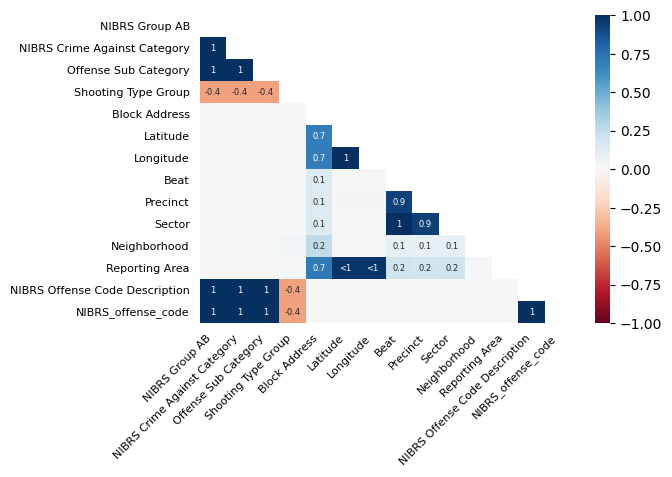

In [ ]:
msno.heatmap(crime_data, figsize=(6,4), fontsize=8)

Based on the correlation heat map:
- NIBRS Group AB, NIBRS Crime Against Category, NIBRS Offense Code Description, and NIBRS_offense_code are all perfectly correlated with each other (1).
- Beat is very strongly correlated (0.9) with Precinct and Sector
- Latitude and Longitude are strongly correlated (0.7)
- Block Address, Latitude, Longitude, and Reporting Area are all strongly correlated with each other (0.7)

## Fill missing values for Neighborhood and Precinct

### Fill missing values for Neighborhood

In [ ]:
crime_data['Neighborhood'].unique()

<StringArray>
[                              <NA>,                'NORTH BEACON HILL',
                   'PIONEER SQUARE',                      'WALLINGFORD',
                   'SOUTH DELRIDGE',                'ROOSEVELT/RAVENNA',
                       'UNIVERSITY',                     'CAPITOL HILL',
              'DOWNTOWN COMMERCIAL',                    'BALLARD NORTH',
         'CENTRAL AREA/SQUIRE PARK',                        'SANDPOINT',
 'CHINATOWN/INTERNATIONAL DISTRICT',                   'MADRONA/LESCHI',
                         'MAGNOLIA',                          'GENESEE',
                           'MORGAN',                       'BITTERLAKE',
                        'NORTHGATE',                         'LAKECITY',
                        'GREENWOOD',                    'BALLARD SOUTH',
                         'BELLTOWN',                        'NEW HOLLY',
                             'SODO',                       'FIRST HILL',
                       'QUEEN ANNE', 

In [ ]:
crime_data.shape

(1484399, 26)

In [ ]:
filling_df = crime_data.dropna(subset=['Latitude', 'Longitude'])
filling_df = filling_df[
    ~(
        filling_df['Latitude'].isin([-1, 1]) &
        filling_df['Longitude'].isin([-1, 1])
    )
]
filling_df = filling_df[(filling_df['Neighborhood'].isna()) | (filling_df['Neighborhood'] == 'UNKNOWN')]

In [ ]:
filling_df.isna().sum()

,0
Report Number,0
Report DateTime,0
Offense ID,0
Offense Date,0
Duration,0
NIBRS Group AB,558
NIBRS Crime Against Category,558
Offense Sub Category,558
Shooting Type Group,469758
Block Address,115


In [ ]:
import geopandas as gpd

url = "https://raw.githubusercontent.com/seattleio/seattle-boundaries-data/master/data/spd-mcpp-areas.geojson"

mcpp = gpd.read_file(url)
mcpp = mcpp.to_crs(epsg=4326)

print(mcpp.columns)
print(mcpp.head())
from shapely.geometry import Point

def get_spd_neighborhood(lat, lon, mcpp_gdf=mcpp):
    pt = Point(lon, lat)   # shapely: (x, y) = (lon, lat)
    hit = mcpp_gdf[mcpp_gdf.contains(pt)]
    if hit.empty:
        return None
    row = hit.iloc[0]
    return row.get("NAME")


Index(['NAME', 'PRECINCT', 'geometry'], dtype='object')
              NAME PRECINCT                                           geometry
0  ALASKA JUNCTION       SW  POLYGON ((-122.38253 47.57018, -122.38145 47.5...
1             ALKI       SW  POLYGON ((-122.37792 47.59466, -122.37567 47.5...
2    BALLARD NORTH        N  POLYGON ((-122.3816 47.70895, -122.38064 47.70...
3    BALLARD SOUTH        N  POLYGON ((-122.40539 47.67582, -122.40535 47.6...
4         BELLTOWN        W  POLYGON ((-122.36275 47.61858, -122.36096 47.6...


In [ ]:
filling_df["Neighborhood"] = filling_df.apply(
    lambda row: get_spd_neighborhood(row["Latitude"], row["Longitude"]), axis=1
)

In [ ]:
filling_df[filling_df['Neighborhood'].isna()].shape

(3169, 26)

In [ ]:
filling_df['Neighborhood'].unique()

array(['ROOSEVELT/RAVENNA', 'LAKECITY', 'PHINNEY RIDGE', 'CAPITOL HILL',
       'BALLARD SOUTH', 'DOWNTOWN COMMERICAL', 'UNIVERSITY',
       'HILLMAN CITY', 'CENTRAL AREA/SQUIRE PARK', 'BITTERLAKE',
       'SLU/CASCADE', 'NORTH BEACON HILL', 'GENESEE', 'NORTHGATE',
       'QUEEN ANNE', 'MOUNT BAKER', 'SODO', 'MILLER PARK', 'WALLINGFORD',
       'ROXHILL/WESTWOOD/ARBOR HEIGHTS', 'BALLARD NORTH', 'FAUNTLEROY SW',
       'COLUMBIA CITY', 'PIONEER SQUARE', 'FIRST HILL', 'HIGHLAND PARK',
       'BELLTOWN', 'GREENWOOD', 'NEW HOLLY', 'ALASKA JUNCTION',
       'SANDPOINT', 'BRIGHTON/DUNLAP', 'RAINIER VIEW', 'MORGAN',
       'FREMONT', 'EASTLAKE - WEST', 'LAKEWOOD/SEWARD PARK',
       'RAINIER BEACH', 'INTERNATIONAL DISTRICT - EAST',
       'CLAREMONT/RAINIER VISTA', 'SOUTH BEACON HILL',
       'INTERNATIONAL DISTRICT - WEST', 'MID BEACON HILL', 'MAGNOLIA',
       'GEORGETOWN', 'MADRONA/LESCHI', 'JUDKINS PARK',
       'NORTH CAPITOL HILL', 'NORTH DELRIDGE', 'ALKI', 'MADISON PARK',
       None, 

In [ ]:
filling_df.shape

(471491, 26)

In [ ]:
temp = filling_df[filling_df['Neighborhood'].isna()]

In [ ]:
import requests

def get_neighborhood(lat, lon):
    url = "https://services.arcgis.com/ZOyb2t4B0UYuYNYH/arcgis/rest/services/nma_nhoods_sub/FeatureServer/0/query"

    params = {
        "geometry": f"{lon},{lat}",
        "geometryType": "esriGeometryPoint",
        "inSR": 4326,
        "spatialRel": "esriSpatialRelIntersects",
        "outFields": "S_HOOD,L_HOOD",
        "returnGeometry": "false",
        "f": "json"
    }

    try:
        resp = requests.get(url, params=params)
        data = resp.json()

        if "features" not in data or len(data["features"]) == 0:
            return None

        attr = data["features"][0]["attributes"]
        return attr.get("S_HOOD").upper()

    except Exception as e:
        print("Error:", e)
        return None


In [ ]:
def safe_get_nhood(lat, lon):
    try:
        result = get_neighborhood(lat, lon)
        return result if result is not None else "UNKNOWN"
    except Exception:
        return "UNKNOWN"

temp = temp.copy()

temp["Neighborhood"] = temp.apply(
    lambda row: get_neighborhood(row["Latitude"], row["Longitude"]) or "UNKNOWN",
    axis=1
)


In [ ]:
temp[temp['Neighborhood'] != 'UNKNOWN']

,Report Number,Report DateTime,Offense ID,Offense Date,Duration,NIBRS Group AB,NIBRS Crime Against Category,Offense Sub Category,Shooting Type Group,Block Address,...,Reporting Area,Offense Category,NIBRS Offense Code Description,NIBRS_offense_code,Report_Year,Report_Month,Report_Day,Offense_Year,Offense_Month,Offense_Day
8131,2009-243755,2009-07-13 15:10:00,7697228738,2009-07-13 10:30:00,0 days 04:40:00,A,PROPERTY,LARCENY-THEFT,<NA>,15XX BLOCK OF NE 145TH ST,...,10405,PROPERTY CRIME,Theft From Motor Vehicle,23F,2009,7,13,2009,7,13
8235,2016-194271,2016-06-02 10:04:00,7648534468,2016-06-02 08:45:00,0 days 01:19:00,B,ANY,ALL OTHER,<NA>,AURORA AVE N / N 145TH ST,...,3854,ALL OTHER,All Other Offenses,90Z,2016,6,2,2016,6,2
9063,2018-476361,2018-12-21 22:05:00,7640760448,2018-12-21 22:05:00,0 days 00:00:00,B,ANY,ALL OTHER,<NA>,SW ROXBURY ST / 26TH AVE SW,...,9989,ALL OTHER,All Other Offenses,90Z,2018,12,21,2018,12,21
9657,2008-442308,2008-11-25 18:31:00,7682064462,2008-11-25 18:31:00,0 days 00:00:00,B,ANY,ALL OTHER,<NA>,15XX BLOCK OF NE 145TH ST,...,10405,ALL OTHER,All Other Offenses,90Z,2008,11,25,2008,11,25
15228,2010-348347,2010-10-05 13:40:00,7667229245,2010-10-05 13:40:00,0 days 00:00:00,B,ANY,ALL OTHER,<NA>,AURORA AVE N / N 145TH ST,...,3854,ALL OTHER,All Other Offenses,90Z,2010,10,5,2010,10,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469590,2011-139041,2011-05-02 03:12:00,7635610429,2011-05-02 02:31:00,0 days 00:41:00,B,ANY,ALL OTHER,<NA>,AURORA AVE N / N 145TH ST,...,3854,ALL OTHER,All Other Offenses,90Z,2011,5,2,2011,5,2
1473810,2009-332584,2009-09-20 01:33:00,7700558257,2009-09-19 23:56:00,0 days 01:37:00,A,PERSON,ASSAULT OFFENSES,<NA>,15XX BLOCK OF NE 145TH ST,...,10405,ALL OTHER,Simple Assault,13B,2009,9,20,2009,9,19
1474613,2012-326207,2012-09-25 11:32:00,7698900091,2012-09-25 11:32:00,0 days 00:00:00,A,PROPERTY,LARCENY-THEFT,<NA>,15XX BLOCK OF NE 145TH ST,...,10405,PROPERTY CRIME,Shoplifting,23C,2012,9,25,2012,9,25
1476236,2009-411308,2009-11-26 13:06:00,7644442976,2009-11-26 13:06:00,0 days 00:00:00,B,ANY,ALL OTHER,<NA>,AURORA AVE N / N 145TH ST,...,3854,ALL OTHER,All Other Offenses,90Z,2009,11,26,2009,11,26


In [ ]:
temp.head()

,Report Number,Report DateTime,Offense ID,Offense Date,Duration,NIBRS Group AB,NIBRS Crime Against Category,Offense Sub Category,Shooting Type Group,Block Address,...,Reporting Area,Offense Category,NIBRS Offense Code Description,NIBRS_offense_code,Report_Year,Report_Month,Report_Day,Offense_Year,Offense_Month,Offense_Day
873,2025-910289,2025-06-14 16:46:55,64522748962,2025-06-07 13:25:00,7 days 03:21:55,A,PROPERTY,LARCENY-THEFT,<NA>,81XX BLOCK OF S 121ST ST,...,99,PROPERTY CRIME,All Other Larceny,23H,2025,6,14,2025,6,7
925,2021-032561,2021-02-08 02:16:37,20410285556,2021-02-08 00:04:00,0 days 02:12:37,A,PERSON,ASSAULT OFFENSES,<NA>,116XX BLOCK OF AMBAUM BLVD SW,...,99,ALL OTHER,Intimidation,13C,2021,2,8,2021,2,8
3173,2017-910221,2017-11-08 10:55:00,7631697797,2017-11-07 08:45:00,1 days 02:10:00,A,PROPERTY,LARCENY-THEFT,<NA>,98XX BLOCK OF 28TH AVE SW,...,9989,PROPERTY CRIME,All Other Larceny,23H,2017,11,8,2017,11,7
3857,2018-463525,2018-12-12 22:48:00,7670992344,2018-12-12 18:52:00,0 days 03:56:00,B,ANY,ALL OTHER,<NA>,N 155TH ST / AURORA AVE N,...,9986,ALL OTHER,All Other Offenses,90Z,2018,12,12,2018,12,12
5236,2024-934597,2024-07-07 05:51:58,57458107633,2024-07-06 00:00:00,1 days 05:51:58,A,PROPERTY,LARCENY-THEFT,<NA>,16XX BLOCK OF SW 114TH ST,...,99,PROPERTY CRIME,All Other Larceny,23H,2024,7,7,2024,7,6


In [ ]:
temp[temp['Neighborhood'].isna()]

,Report Number,Report DateTime,Offense ID,Offense Date,Duration,NIBRS Group AB,NIBRS Crime Against Category,Offense Sub Category,Shooting Type Group,Block Address,...,Reporting Area,Offense Category,NIBRS Offense Code Description,NIBRS_offense_code,Report_Year,Report_Month,Report_Day,Offense_Year,Offense_Month,Offense_Day


In [ ]:
temp['Neighborhood'].unique()

array(['UNKNOWN', 'OLYMPIC HILLS', 'HALLER LAKE', 'SOUTH DELRIDGE',
       'BROADVIEW', 'RAINIER VIEW', 'BITTER LAKE', 'SOUTH PARK',
       'HIGHLAND PARK', 'PINEHURST', 'ARBOR HEIGHTS'], dtype=object)

In [ ]:
filling_df['Neighborhood'].unique()

array(['ROOSEVELT/RAVENNA', 'LAKECITY', 'PHINNEY RIDGE', 'CAPITOL HILL',
       'BALLARD SOUTH', 'DOWNTOWN COMMERICAL', 'UNIVERSITY',
       'HILLMAN CITY', 'CENTRAL AREA/SQUIRE PARK', 'BITTERLAKE',
       'SLU/CASCADE', 'NORTH BEACON HILL', 'GENESEE', 'NORTHGATE',
       'QUEEN ANNE', 'MOUNT BAKER', 'SODO', 'MILLER PARK', 'WALLINGFORD',
       'ROXHILL/WESTWOOD/ARBOR HEIGHTS', 'BALLARD NORTH', 'FAUNTLEROY SW',
       'COLUMBIA CITY', 'PIONEER SQUARE', 'FIRST HILL', 'HIGHLAND PARK',
       'BELLTOWN', 'GREENWOOD', 'NEW HOLLY', 'ALASKA JUNCTION',
       'SANDPOINT', 'BRIGHTON/DUNLAP', 'RAINIER VIEW', 'MORGAN',
       'FREMONT', 'EASTLAKE - WEST', 'LAKEWOOD/SEWARD PARK',
       'RAINIER BEACH', 'INTERNATIONAL DISTRICT - EAST',
       'CLAREMONT/RAINIER VISTA', 'SOUTH BEACON HILL',
       'INTERNATIONAL DISTRICT - WEST', 'MID BEACON HILL', 'MAGNOLIA',
       'GEORGETOWN', 'MADRONA/LESCHI', 'JUDKINS PARK',
       'NORTH CAPITOL HILL', 'NORTH DELRIDGE', 'ALKI', 'MADISON PARK',
       None, 

In [ ]:
list(crime_data['Neighborhood'].unique())

[<NA>,
 'NORTH BEACON HILL',
 'PIONEER SQUARE',
 'WALLINGFORD',
 'SOUTH DELRIDGE',
 'ROOSEVELT/RAVENNA',
 'UNIVERSITY',
 'CAPITOL HILL',
 'DOWNTOWN COMMERCIAL',
 'BALLARD NORTH',
 'CENTRAL AREA/SQUIRE PARK',
 'SANDPOINT',
 'CHINATOWN/INTERNATIONAL DISTRICT',
 'MADRONA/LESCHI',
 'MAGNOLIA',
 'GENESEE',
 'MORGAN',
 'BITTERLAKE',
 'NORTHGATE',
 'LAKECITY',
 'GREENWOOD',
 'BALLARD SOUTH',
 'BELLTOWN',
 'NEW HOLLY',
 'SODO',
 'FIRST HILL',
 'QUEEN ANNE',
 'FREMONT',
 'PHINNEY RIDGE',
 'BRIGHTON/DUNLAP',
 'ROXHILL/WESTWOOD/ARBOR HEIGHTS',
 'PIGEON POINT',
 'NORTH ADMIRAL',
 'MOUNT BAKER',
 'HIGH POINT',
 'ALASKA JUNCTION',
 'MILLER PARK',
 'LAKEWOOD/SEWARD PARK',
 'SOUTH PARK',
 'RAINIER BEACH',
 'JUDKINS PARK/NORTH BEACON HILL',
 'GEORGETOWN',
 'SLU/CASCADE',
 'CLAREMONT/RAINIER VISTA',
 'RAINIER VIEW',
 'EASTLAKE - WEST',
 'EASTLAKE - EAST',
 'NORTH DELRIDGE',
 'HILLMAN CITY',
 'MID BEACON HILL',
 'MONTLAKE/PORTAGE BAY',
 'SOUTH BEACON HILL',
 'COLUMBIA CITY',
 'HIGHLAND PARK',
 'FAUNTLERO

In [ ]:
crime_data[crime_data['Neighborhood'] == 'UNKNOWN']

,Report Number,Report DateTime,Offense ID,Offense Date,Duration,NIBRS Group AB,NIBRS Crime Against Category,Offense Sub Category,Shooting Type Group,Block Address,...,Reporting Area,Offense Category,NIBRS Offense Code Description,NIBRS_offense_code,Report_Year,Report_Month,Report_Day,Offense_Year,Offense_Month,Offense_Day


In [ ]:
import pandas as pd
import numpy as np
replacement_map = {
    # Typos
    'DOWNTOWN COMMERICAL': 'DOWNTOWN COMMERCIAL',
    'MID BEACON HIL': 'MID BEACON HILL',

    # Consolidations
    'INTERNATIONAL DISTRICT - EAST': 'CHINATOWN/INTERNATIONAL DISTRICT',
    'INTERNATIONAL DISTRICT - WEST': 'CHINATOWN/INTERNATIONAL DISTRICT',
    'JUDKINS PARK': 'JUDKINS PARK/NORTH BEACON HILL',
    'NORTH BEACON/JEFFERSON PARK': 'JUDKINS PARK/NORTH BEACON HILL',
    'NORTH CAPITOL HILL': 'CAPITOL HILL',
    'MT BAKER/NORTH RAINIER': 'MOUNT BAKER'
    # None: 'UNKNOWN',
    # np.nan: 'UNKNOWN'
}
filling_df['Neighborhood'] = filling_df['Neighborhood'].replace(replacement_map)

In [ ]:
filling_df.loc[temp.index, 'Neighborhood'] = temp['Neighborhood']

In [ ]:
crime_data.loc[filling_df.index, 'Neighborhood'] = filling_df['Neighborhood']

In [ ]:
crime_data.fillna({'Neighborhood': 'UNKNOWN'}, inplace=True)

### Fill Precinct missing values

In [ ]:
mcpp2 = mcpp.to_crs(epsg=4326)
def get_precinct(lat, lon, mcpp_gdf=mcpp2):
  pt = Point(lon, lat) # shapely: (x, y) = (lon, lat)
  hit = mcpp_gdf[mcpp_gdf.contains(pt)]
  if hit.empty:
    return None
  row = hit.iloc[0]
  return row['PRECINCT']

In [ ]:
del temp
temp = filling_df[filling_df['Precinct'].isna()].copy()
temp["Precinct"] = temp.apply(
    lambda row: get_precinct(row["Latitude"], row["Longitude"]), axis=1
)

In [ ]:
temp[~temp["Precinct"].isna()].shape

(324, 26)

In [ ]:
temp['Precinct'].isna().sum()

np.int64(18)

In [ ]:
temp['Precinct'].unique()

array(['E', 'W', 'N', 'SW', 'S', None], dtype=object)

In [ ]:
precinct_replacement_map = {
    # Standard SPD precinct codes → Full names
    'N': 'North',
    'W': 'West',
    'E': 'East',
    'S': 'South',
    'SW': 'Southwest',
}
temp['Precinct'] = temp['Precinct'].replace(precinct_replacement_map)

In [ ]:
filling_df.loc[temp.index, 'Precinct'] = temp['Precinct']

In [ ]:
filling_df.isna().sum()

,0
Report Number,0
Report DateTime,0
Offense ID,0
Offense Date,0
Duration,0
NIBRS Group AB,558
NIBRS Crime Against Category,558
Offense Sub Category,558
Shooting Type Group,469758
Block Address,115


In [ ]:
crime_data.isna().sum()

,0
Report Number,0
Report DateTime,0
Offense ID,0
Offense Date,0
Duration,0
NIBRS Group AB,1602
NIBRS Crime Against Category,1602
Offense Sub Category,1602
Shooting Type Group,1474833
Block Address,387088


In [ ]:
del temp

# Exploratory Data Analysis (EDA)

### Crimes trend over *years*

Check from which year, its data covers 12 months for comparing

In [ ]:
temp = crime_data.groupby(['Offense_Year'])['Offense_Month'].nunique()
years_with_12_months = temp[temp == 12].index.tolist()
years_with_12_months

[2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023,
 2024]

We can see that from 2000 to 2024, all years have data for all months which means that we can use them for comparison

The number of crime by months, years

In [ ]:
crime_data_agg = (
    crime_data[crime_data['Offense_Year'].isin(years_with_12_months)]
    .groupby(['Offense_Year', 'Offense_Month'])['Report Number']
    .agg('count')
    .reset_index(name='Report_Count')
)
crime_data_agg.head()

,Offense_Year,Offense_Month,Report_Count
0,2000,1,38
1,2000,2,2
2,2000,3,9
3,2000,4,2
4,2000,5,6


Crime over years

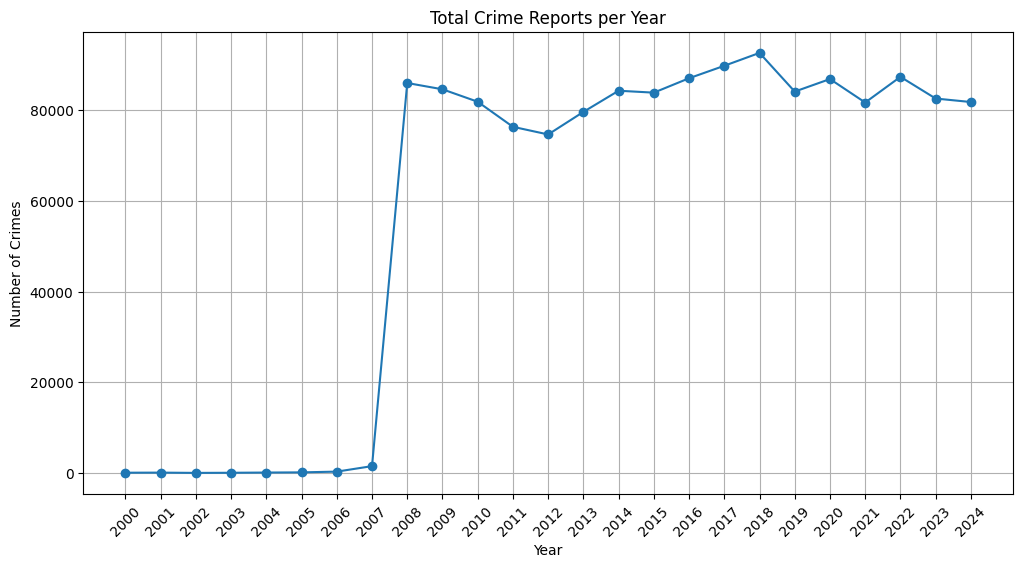

In [ ]:
yearly_crime = crime_data_agg.groupby('Offense_Year')['Report_Count'].sum()
plt.figure(figsize=(12, 6))
plt.plot(yearly_crime.index, yearly_crime.values, marker='o')
plt.title('Total Crime Reports per Year')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.xticks(yearly_crime.index, rotation=45)
plt.show()

- From the yearly crime chart, we can see that the crime was increasing dramatically from 2007. Possibly, **since 2008**, people have known how to report data correctly.
- From 2008 to 2024, it represents a high-level fluctuation. After the initial spike, the number of reports remains at a high level, fluctuating for the most part between 75,000 and 92,000.

Scaling the chart to repsent data from 2008 to 2024

In [ ]:
crime_data = crime_data[(crime_data['Offense_Year'] >= 2008) & (crime_data['Offense_Year'] <= 2024)]

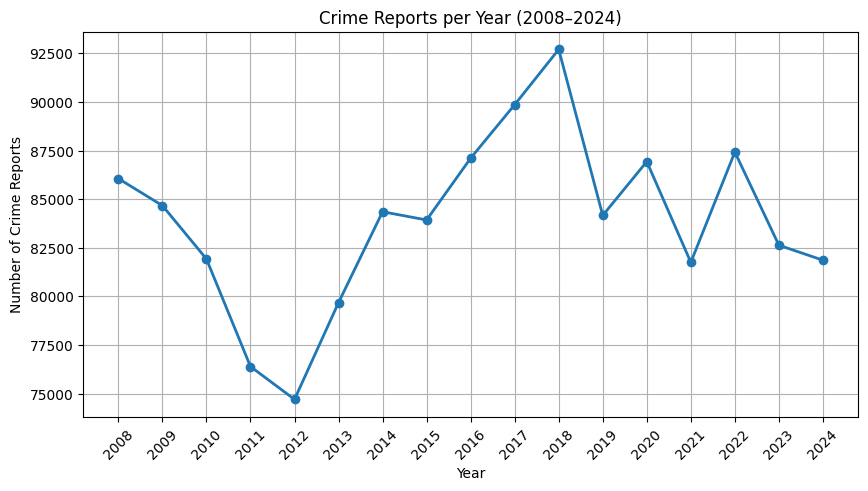

In [ ]:
# Filter data for 2008 to 2024
crime_recent = crime_data_agg[
    (crime_data_agg['Offense_Year'] >= 2008) &
    (crime_data_agg['Offense_Year'] <= 2024)
]

# Aggregate yearly crime counts
recent_yearly_crime = crime_recent.groupby('Offense_Year')['Report_Count'].sum()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(recent_yearly_crime.index, recent_yearly_crime.values, marker='o', linewidth=2)
plt.title('Crime Reports per Year (2008–2024)')
plt.xlabel('Year')
plt.ylabel('Number of Crime Reports')
plt.grid(True)
plt.xticks(recent_yearly_crime.index, rotation=45)
plt.show()

Trends from 2008 to 2024:
- From 2008 to 2012: A steady decline from 2008 to 2012, reaching the lowest point on the chart in 2012 (just under 75,000 reports).
- From 2012 to 2018: There is a strong and consistent increase for six years. This trend leads to the chart's peak in 2018, with the highest number of reports recorded (approximately 92,700).
- From 2018 to 2024: There is a sharp drop from 2018 to 2019. This is followed by another sharp drop from 2020 to 2021. Then, a very sharp increase occurs from 2021 to 2022. The chart ends with a downward trend from 2022 to 2024, with the final data point resting around 82,000 reports.

<Axes: xlabel='Offense Sub Category'>

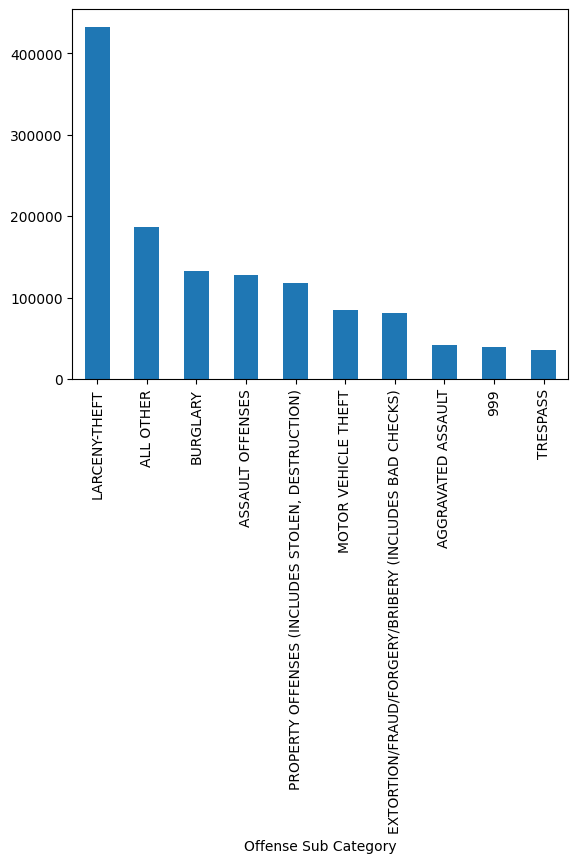

In [ ]:
crime_data['Offense Sub Category'].value_counts().head(10).plot.bar()

--- Top 20 Neighborhoods by Crime Count ---
Neighborhood
DOWNTOWN COMMERCIAL                 107992
CAPITOL HILL                         79131
NORTHGATE                            69027
QUEEN ANNE                           57290
SLU/CASCADE                          55902
UNIVERSITY                           49186
FIRST HILL                           41054
ROOSEVELT/RAVENNA                    38764
BALLARD SOUTH                        37889
BELLTOWN                             35462
CHINATOWN/INTERNATIONAL DISTRICT     33409
LAKECITY                             29549
CENTRAL AREA/SQUIRE PARK             28765
SODO                                 22572
GREENWOOD                            22407
PIONEER SQUARE                       20780
FREMONT                              20606
BITTERLAKE                           19915
NORTH BEACON HILL                    19505
SANDPOINT                            19459
Name: count, dtype: Int64


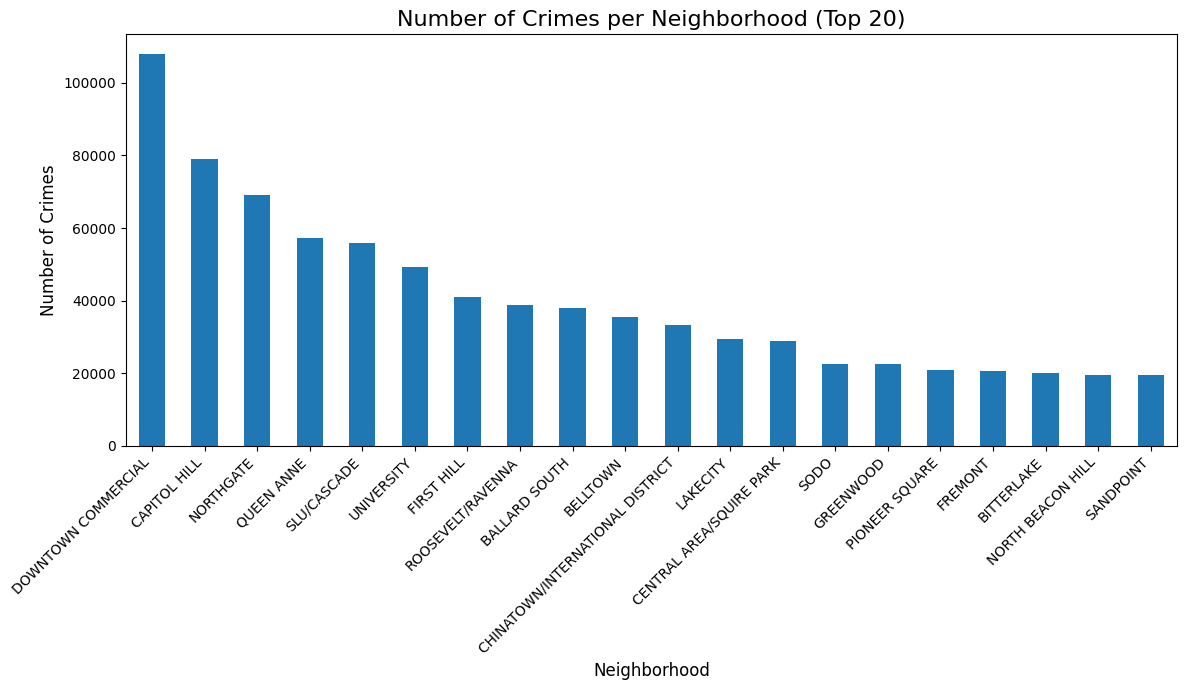

In [ ]:
# Filter out UNKNOWN neighborhood
filtered = crime_data[crime_data['Neighborhood'] != 'UNKNOWN']

# Get the crime counts per neighborhood (Top 20) in descending order
top_20_neighborhoods = filtered['Neighborhood'].value_counts().nlargest(20)

print("--- Top 20 Neighborhoods by Crime Count ---")
print(top_20_neighborhoods)

# Create the bar plot
plt.figure(figsize=(12, 7))
top_20_neighborhoods.plot(kind='bar')
plt.title('Number of Crimes per Neighborhood (Top 20)', fontsize=16)
plt.ylabel('Number of Crimes', fontsize=12)
plt.xlabel('Neighborhood', fontsize=12)

# Rotate the x-axis labels to prevent them from overlapping
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

The plot shows that crime occurrences are not evenly distributed across Seattle neighborhoods. *Downtown Commercial* has the highest reported crime count by a significant margin, followed by *Capitol Hill*, *Northgate*, and *Queen Anne*. These areas are among Seattle’s most active commercial, transit, and nightlife hubs, which naturally lead to higher population density and foot traffic. Residential and mixed-use neighborhoods such as *Roosevelt/Ravenna*, *Lake City*, and *Ballard* areas also show elevated crime levels, though not as high as the central commercial zones. The concentration of crime in these neighborhoods may reflect differences in economic activity, social environments, and urban infrastructure.

### Unique values for each column

In [ ]:
print(crime_data.nunique())

Report Number                     1260840
Report DateTime                   1190104
Offense ID                        1426197
Offense Date                       857426
Duration                           264674
NIBRS Group AB                          2
NIBRS Crime Against Category            5
Offense Sub Category                   30
Shooting Type Group                     3
Block Address                       35116
Latitude                            47014
Longitude                           91399
Beat                                   53
Precinct                                6
Sector                                 19
Neighborhood                           66
Reporting Area                      10742
Offense Category                        3
NIBRS Offense Code Description         64
NIBRS_offense_code                     64
Report_Year                            18
Report_Month                           12
Report_Day                             31
Offense_Year                      

As we can see from the list of columns with their counts of unique values, the *Offense Category* has 3 unique values. Let's plot them to get a sense of their dristribution in the dataset

### Crime Type Distribution

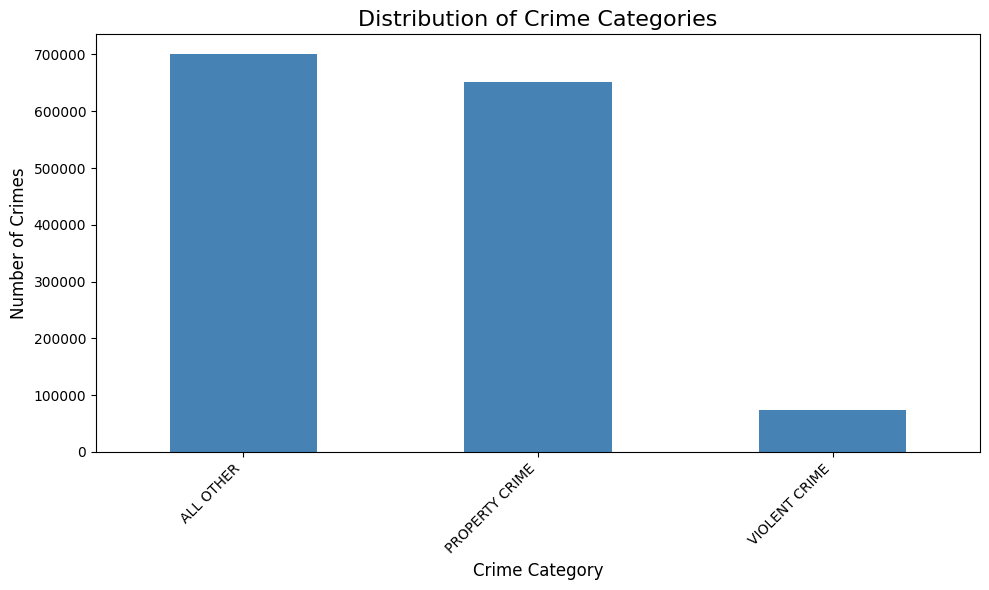

In [ ]:
plt.figure(figsize=(10,6))
crime_data['Offense Category'].value_counts().plot(kind='bar', color='steelblue')
plt.title('Distribution of Crime Categories', fontsize=16)
plt.xlabel('Crime Category', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The dataset includes three primary crime categories: *Property*, *Other*, and *Violent offenses*. *Property crimes* are by far the most common, making up the majority of reported incidents. *Violent crimes* represent a relatively small proportion of total offenses, which may indicate that severe personal harm incidents are less frequent compared to theft- and property-related incidents. However, because this coarse categorization groups many offense types into broad labels, it provides limited insight into which specific types of crime are driving these patterns. Therefore, a more detailed analysis of offense sub-categories is necessary to understand the nature of crime in Seattle more precisely.

### Top 15 Offense Sub-categories

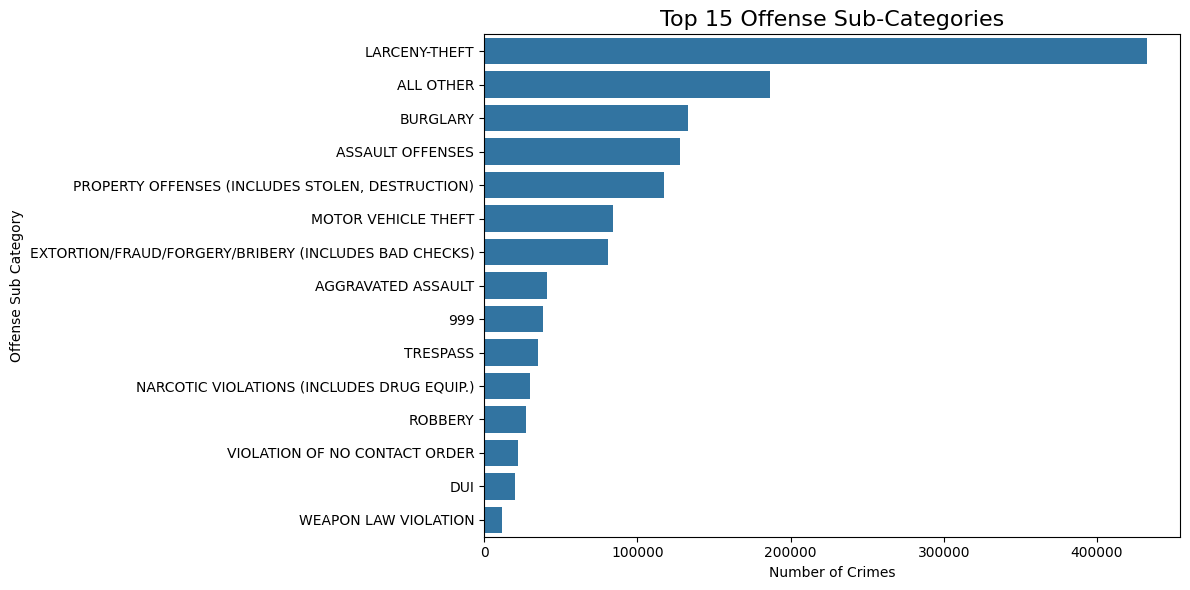

In [ ]:
top_subcategories = crime_data['Offense Sub Category'].value_counts().head(15)

plt.figure(figsize=(12,6))
sns.barplot(x=top_subcategories.values, y=top_subcategories.index)
plt.title('Top 15 Offense Sub-Categories', fontsize=16)
plt.xlabel('Number of Crimes')
plt.ylabel('Offense Sub Category')
plt.tight_layout()
plt.show()

Among the offense subcategories, Larceny-Theft overwhelmingly dominates, with over 400,000 recorded incidents. This aligns with national crime trends, where theft is typically the most common reported offense. The second most frequent category is All Other Offenses, which is a broad classification that may include miscellaneous or less clearly defined crimes. Burglary and Assault Offenses follow closely, indicating that both property invasion and personal harm offenses are also notable contributors to overall crime rates. Lower-frequency categories such as Weapon Law Violations appear near the bottom of the ranking. This distribution reinforces that property-related offenses are the primary drivers of crime volume in Seattle.

### Crime Report Frequency by Hour of Day (Across all years)

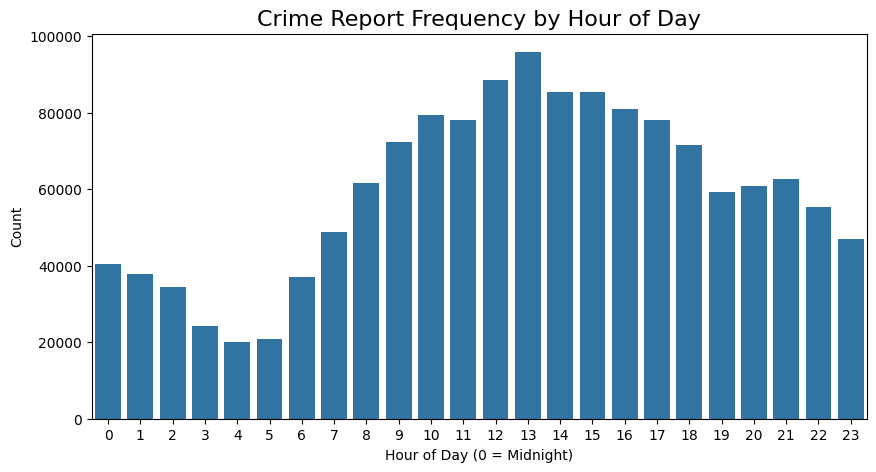

In [ ]:
crime_data['Report_Hour'] = crime_data['Report DateTime'].dt.hour
plt.figure(figsize=(10,5))
sns.countplot(data=crime_data, x='Report_Hour')
plt.title('Crime Report Frequency by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day (0 = Midnight)')
plt.ylabel('Count')
plt.show()

The frequency of reported crimes peaks between late morning and early evening, particularly between 9 AM and 6 PM. This trend may reflect when victims, businesses, and bystanders are most likely to notice and report incidents. In contrast, reported crime counts are much lower during overnight hours, especially between 12 AM and 5 AM, when fewer people are awake or available to report. It is important to note that this graph reflects reporting times, not necessarily when crimes occur; reporting is influenced by work schedules, police availability, and citizen activity patterns.

### Offense Frequency by Hour of Day (Across all years)

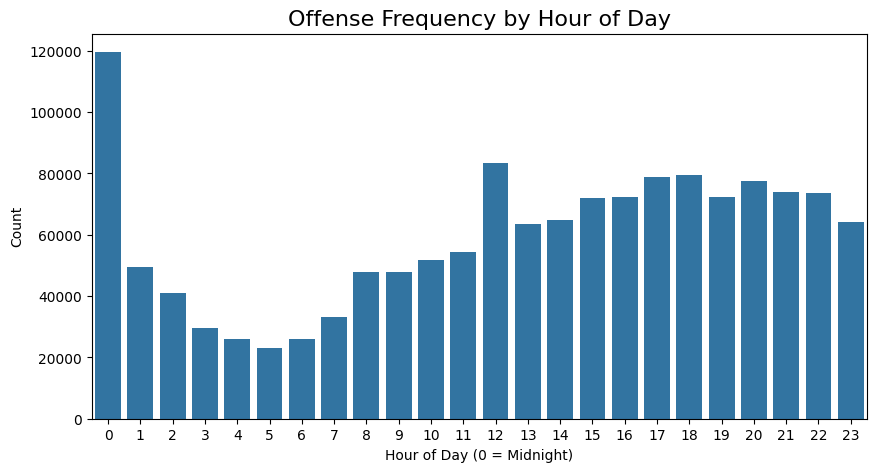

In [ ]:
crime_data['Offense_Hour'] = crime_data['Offense Date'].dt.hour
plt.figure(figsize=(10,5))
sns.countplot(data=crime_data, x='Offense_Hour')
plt.title('Offense Frequency by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day (0 = Midnight)')
plt.ylabel('Count')
plt.show()

When examining the actual time crimes occur, a different pattern emerges. The highest concentration of offenses occurs around midnight, suggesting increased criminal activity during late-night hours, possibly associated with nightlife, reduced visibility, and fewer witnesses. A second peak occurs around noon, likely tied to workday movement and commercial activity. Crime occurrence decreases steadily during the early morning (2 AM – 6 AM), then rises again through the daytime and evening. The contrast between this plot and the reporting-time plot highlights that crimes committed at night are often reported later, contributing to the reporting-time shift observed earlier.

### Crime Report Frequency by Day (Across all years)

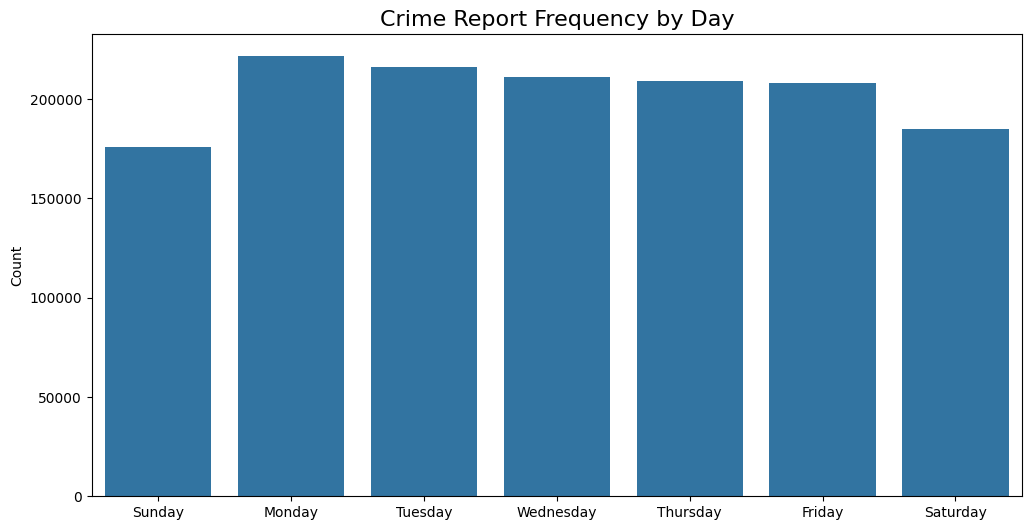

In [ ]:
crime_data['Report_DayOfWeek'] = crime_data['Report DateTime'].dt.day_name()
sunday_start_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
plt.figure(figsize=(12, 6))
sns.countplot(data=crime_data, x='Report_DayOfWeek', order=sunday_start_order)
plt.title('Crime Report Frequency by Day', fontsize=16)
plt.xlabel('')
plt.ylabel('Count')
plt.show()

Reports are highest on Monday, which may be due to delayed reporting following weekend activities or reduced staffing and business hours over Saturday and Sunday. Sunday has the lowest number of crime reports, followed by Saturday, both of which may reflect reduced institutional reporting (e.g., fewer offices, agencies, or businesses open to file reports). This again reflects reporting behavior, not necessarily when crime occurs.

### Offense Frequency by Day (Across all years)

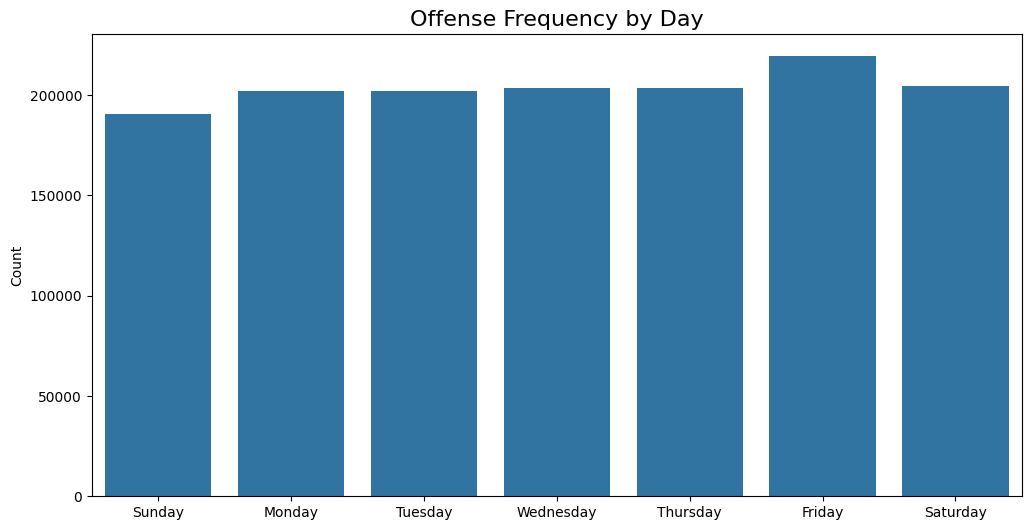

In [ ]:
crime_data['Offense_DayOfWeek'] = crime_data['Offense Date'].dt.day_name()
plt.figure(figsize=(12, 6))
sns.countplot(data=crime_data, x='Offense_DayOfWeek', order=sunday_start_order)
plt.title('Offense Frequency by Day', fontsize=16)
plt.xlabel('')
plt.ylabel('Count')
plt.show()

When examining when crimes actually occur, Friday has the highest offense count, consistent with increased social activity, nightlife, and mobility at the end of the work week. Sunday records the lowest crime occurrence. Other weekdays have relatively similar crime levels with minor variation. This pattern suggests that crime frequency is influenced by social behaviors and weekly activity cycles rather than institutional reporting patterns.

### Overall Crime Trend by Month (Across all years)

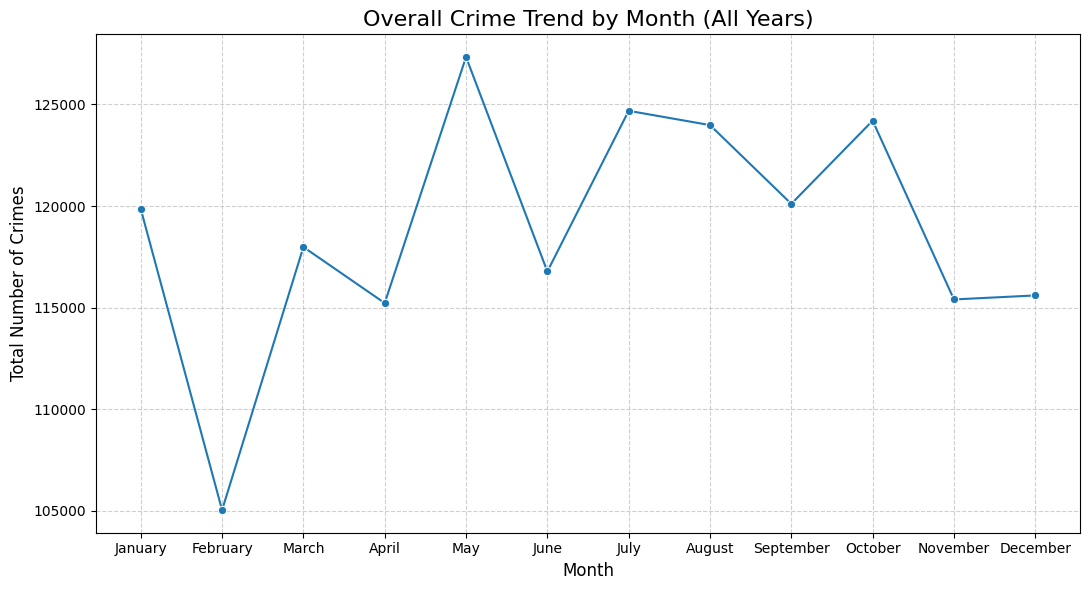

In [ ]:
# Get the counts for each month using the 'Offense_Month' column
month_counts = crime_data['Offense_Month'].value_counts()

# Sort the counts chronologically (by month number 1-12)
month_counts = month_counts.sort_index()

# Create a mapping from month number to month name
month_map = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# Prepare data for Seaborn
# Convert the sorted Series to a DataFrame
plot_data = month_counts.reset_index()
plot_data.columns = ['Month_Number', 'Number of Crimes']

# Map the month numbers to month names for a readable x-axis
plot_data['Month'] = plot_data['Month_Number'].map(month_map)

# Create the line plot
plt.figure(figsize=(11, 6))
sns.lineplot(
    data=plot_data,
    x='Month',
    y='Number of Crimes',
    marker='o',
    sort=False
)

# Customize the plot
plt.title('Overall Crime Trend by Month (All Years)', fontsize=16)
plt.ylabel('Total Number of Crimes', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

In [ ]:
# Years to compare
target_years = [2019, 2020, 2021, 2022, 2023]

# Filter the DataFrame to only our target years
df_filtered = crime_data[crime_data['Offense_Year'].isin(target_years)]

# Group by both Year and Month and get the counts
plot_data = df_filtered.groupby(['Offense_Year', 'Offense_Month']).size().reset_index(name='Number of Crimes')

# Ensure all year-month combos exist
# This fills in '0' for any month in a year that had no crimes
all_years = pd.Index(target_years, name='Offense_Year')
all_months = pd.Index(range(1, 13), name='Offense_Month')
full_grid = pd.MultiIndex.from_product([all_years, all_months]).to_frame(index=False)
plot_data = pd.merge(full_grid, plot_data, on=['Offense_Year', 'Offense_Month'], how='left')
plot_data['Number of Crimes'] = plot_data['Number of Crimes'].fillna(0).astype(int)

# Map month numbers to names and sort
month_map = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
}
plot_data['Month'] = plot_data['Offense_Month'].map(month_map)
plot_data = plot_data.sort_values(by='Offense_Month')

print(plot_data.head())

    Offense_Year  Offense_Month  Number of Crimes    Month
0           2019              1              7742  January
12          2020              1              7043  January
24          2021              1              6557  January
36          2022              1              7673  January
48          2023              1              6656  January


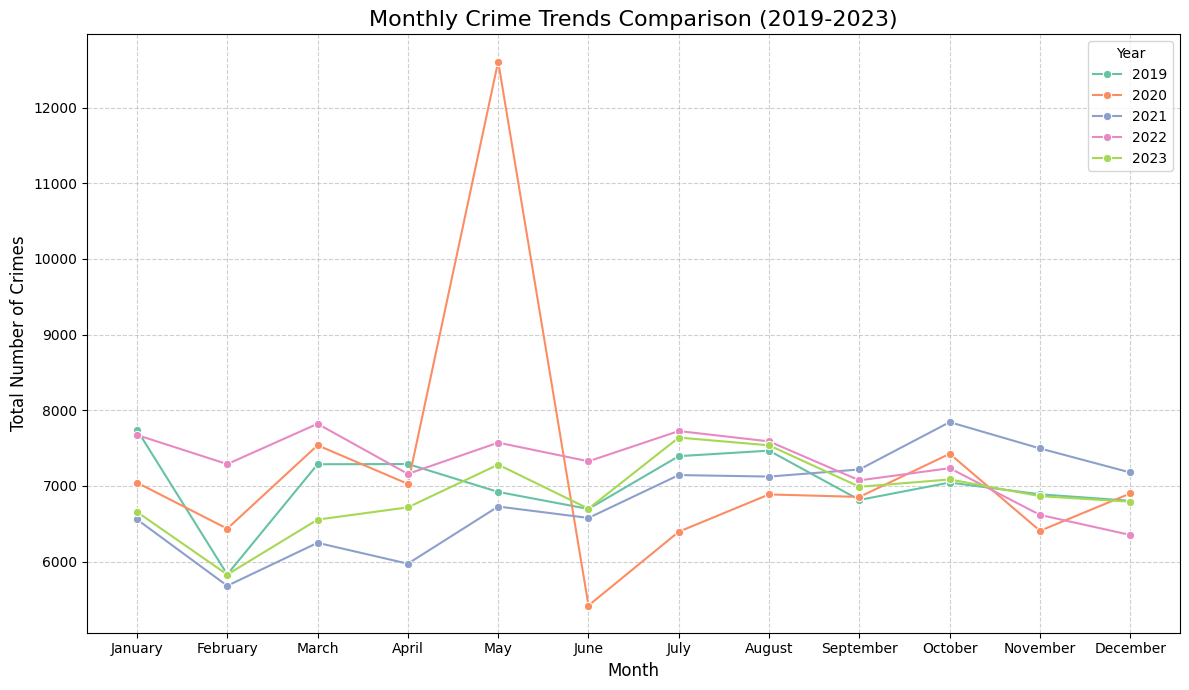

In [ ]:
# Create the figure
plt.figure(figsize=(12, 7))

# Draw the line plot
sns.lineplot(
    data=plot_data,
    x='Month',
    y='Number of Crimes',
    hue='Offense_Year',
    marker='o',
    palette='Set2',
    sort=False
)

plt.title('Monthly Crime Trends Comparison (2019-2023)', fontsize=16)
plt.ylabel('Total Number of Crimes', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.legend(title='Year')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

###Duration (Difference between report time and offense time) per neighborhood

In [ ]:
duration_neighbor = crime_data[['Duration', 'Neighborhood']].copy()
duration_neighbor.dropna(subset='Neighborhood', inplace=True)
duration_neighbor

,Duration,Neighborhood
0,0 days 02:17:00,ROOSEVELT/RAVENNA
1,0 days 17:22:00,LAKECITY
2,0 days 06:59:00,PHINNEY RIDGE
3,0 days 00:47:00,CAPITOL HILL
4,0 days 19:17:05,NORTH BEACON HILL
...,...,...
1484394,0 days 03:11:26,SANDPOINT
1484395,0 days 01:25:00,UNKNOWN
1484396,0 days 05:13:40,DOWNTOWN COMMERCIAL
1484397,0 days 00:00:00,UNKNOWN


Check whether there is an event where reporting happens before offense time

In [ ]:
report_before_offense = crime_data[crime_data['Report DateTime'] < crime_data['Offense Date']]
report_before_offense.head()

,Report Number,Report DateTime,Offense ID,Offense Date,Duration,NIBRS Group AB,NIBRS Crime Against Category,Offense Sub Category,Shooting Type Group,Block Address,...,Report_Year,Report_Month,Report_Day,Offense_Year,Offense_Month,Offense_Day,Report_Hour,Offense_Hour,Report_DayOfWeek,Offense_DayOfWeek
816,2024-090710,2024-04-03 23:45:18,55173343739,2024-04-04 00:00:00,-1 days +23:45:18,B,NOT_A_CRIME,999,Shots Fired (Eyewitness/Casings/Property Damage),4TH AVE / PIKE ST,...,2024,4,3,2024,4,4,23,0,Wednesday,Thursday
1453,2020-358081,2021-01-01 00:21:46,19254640542,2021-01-01 00:28:00,-1 days +23:53:46,B,NOT_A_CRIME,999,<NA>,40XX BLOCK OF 28TH AVE SW,...,2021,1,1,2021,1,1,0,0,Friday,Friday
1595,2023-357041,2023-12-12 18:10:40,53387721627,2023-12-12 18:11:00,-1 days +23:59:40,A,PERSON,ASSAULT OFFENSES,<NA>,<NA>,...,2023,12,12,2023,12,12,18,18,Tuesday,Tuesday
2301,2020-040052,2020-02-01 19:45:29,12600619292,2020-02-01 19:55:04,-1 days +23:50:25,B,NOT_A_CRIME,999,<NA>,<NA>,...,2020,2,1,2020,2,1,19,19,Saturday,Saturday
3017,2021-235187,2021-09-08 06:36:39,27987575900,2021-09-08 06:48:00,-1 days +23:48:39,A,PROPERTY,LARCENY-THEFT,<NA>,24XX BLOCK OF UTAH AVE S,...,2021,9,8,2021,9,8,6,6,Wednesday,Wednesday


Visualizing what types of crimes are usually reported before the offense

In [ ]:
report_before_offense = (
    report_before_offense
    .groupby(['NIBRS Crime Against Category', 'Offense Sub Category'])['Report Number']
    .agg(Report_Count='count')
    .reset_index()
)

report_before_offense

,NIBRS Crime Against Category,Offense Sub Category,Report_Count
0,ANY,ALL OTHER,168
1,NOT_A_CRIME,999,383
2,PERSON,AGGRAVATED ASSAULT,50
3,PERSON,ASSAULT OFFENSES,165
4,PERSON,HOMICIDE,1
5,PERSON,HUMAN TRAFFICKING,2
6,PERSON,KIDNAPPING/ABDUCTION,4
7,PERSON,RAPE,7
8,PERSON,SEX OFFENSES,6
9,PERSON,VIOLATION OF NO CONTACT ORDER,15


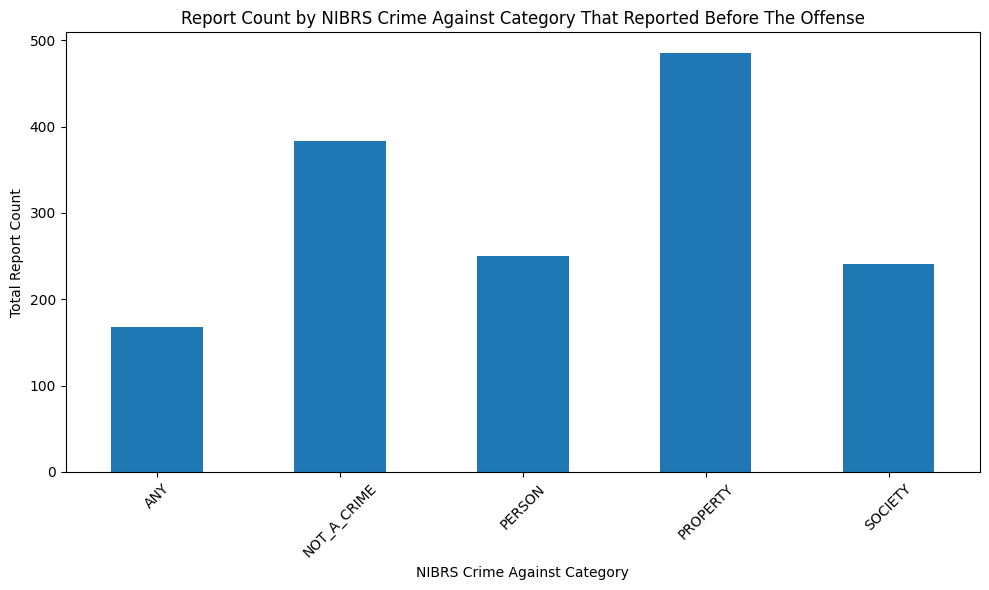

In [ ]:
grouped_data = report_before_offense.groupby('NIBRS Crime Against Category')['Report_Count'].sum()
plt.figure(figsize=(10, 6))
grouped_data.plot(kind='bar')

# Customize the chart
plt.title('Report Count by NIBRS Crime Against Category That Reported Before The Offense')
plt.xlabel('NIBRS Crime Against Category')
plt.ylabel('Total Report Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

- Most of the reporting before the offense is Property crimes reported.
- Following that, it should be noted that people also reporting wrongly about the crime, and in the end, it was not a crime.

/tmp/ipython-input-1729640854.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duration_neighbor['Duration_hours'] = duration_neighbor['Duration'].dt.total_seconds() / 3600


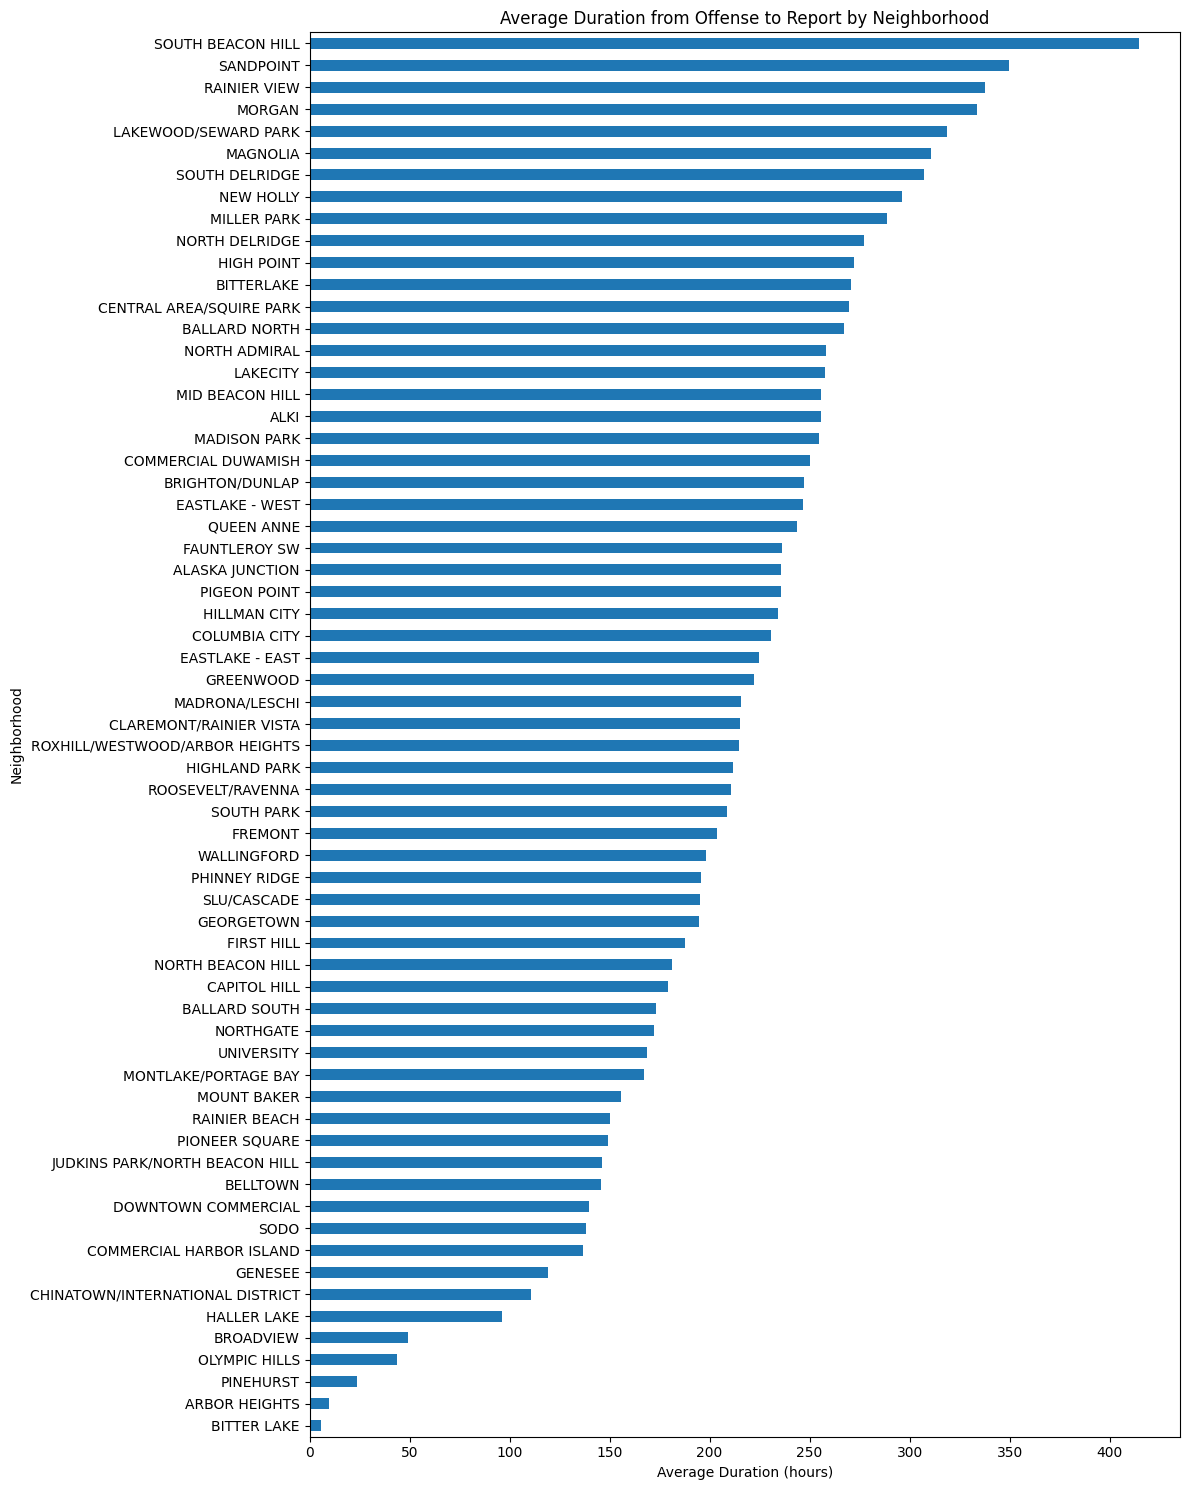

In [ ]:
duration_neighbor = duration_neighbor[~duration_neighbor['Neighborhood'].isin(['OOJ', 'UNKNOWN', 'FK ERROR'])]
duration_neighbor['Duration_hours'] = duration_neighbor['Duration'].dt.total_seconds() / 3600
avg_duration = (duration_neighbor
                .groupby('Neighborhood')['Duration_hours']
                .mean()
                .sort_values())

# Plot
plt.figure(figsize=(12, 15))
avg_duration.plot(kind='barh')  # Horizontal bar chart for better readability
plt.title('Average Duration from Offense to Report by Neighborhood')
plt.xlabel('Average Duration (hours)')
plt.ylabel('Neighborhood')
plt.tight_layout()
plt.show()

- From the chart, we can see that the downtown or crowded areas like Commercial Harbor Island, Sodo, Mount Baker, Chinatown/International District..., the crimes were reported in a short time comparing to other places.
- In some areas like Rainer View, Morgan, South Beacon Hill, SandPoint, Alki..., the crimes were reported lately comparing to other places.

### Crimes trend by Neighborhood

In [ ]:
def plot_crimes_by_hour(neighborhood):
    """Plot number of crimes per hour for the selected neighborhood."""
    df = crime_data[crime_data['Neighborhood'] == neighborhood]
    if df.empty:
        print(f"No data available for {neighborhood}")
        return

    hourly_counts = df['Report_Hour'].value_counts().sort_index()

    plt.figure(figsize=(10,5))
    sns.barplot(x=hourly_counts.index, y=hourly_counts.values, color='steelblue')
    plt.title(f'Crime Report Frequency by Hour - {neighborhood}', fontsize=16)
    plt.xlabel('Hour of Day (0 = Midnight)')
    plt.ylabel('Number of Crimes')
    plt.xticks(range(0, 24))
    plt.show()

In [ ]:
neighborhoods = sorted(crime_data['Neighborhood'].dropna().unique())

interact(plot_crimes_by_hour, neighborhood=widgets.Dropdown(
    options=neighborhoods,
    description='Neighborhood:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
))

interactive(children=(Dropdown(description='Neighborhood:', layout=Layout(width='50%'), options=('ALASKA JUNCT…

<function __main__.plot_crimes_by_hour(neighborhood)>

In [ ]:
def plot_top10_crimes(neighborhood):
    """Show top 10 crime subcategories for the selected neighborhood."""

    df = crime_data[crime_data['Neighborhood'] == neighborhood]

    if df.empty:
        print(f"No data available for {neighborhood}")
        return

    top10 = (df['Offense Sub Category']
             .value_counts()
             .head(10)
             .sort_values(ascending=False))

    plt.figure(figsize=(20, 6))
    sns.barplot(
    x=top10.values,
    y=top10.index,
    hue=top10.index,
    palette="Spectral",
    dodge=False,
    legend=False
    )
    plt.title(f"Top 10 Crime Subcategories in {neighborhood}", fontsize=16)
    plt.xlabel("Number of Crimes")
    plt.ylabel("Offense Sub Category")
    plt.tight_layout()
    plt.show()

In [ ]:
neighborhood_selector = widgets.Dropdown(
    options=sorted(crime_data['Neighborhood'].dropna().unique()),
    description='Neighborhood:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

interact(plot_top10_crimes, neighborhood=neighborhood_selector)

interactive(children=(Dropdown(description='Neighborhood:', layout=Layout(width='50%'), options=('ALASKA JUNCT…

<function __main__.plot_top10_crimes(neighborhood)>

In [ ]:
!pip install phik

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 10.8 MB/s eta 0:00:00


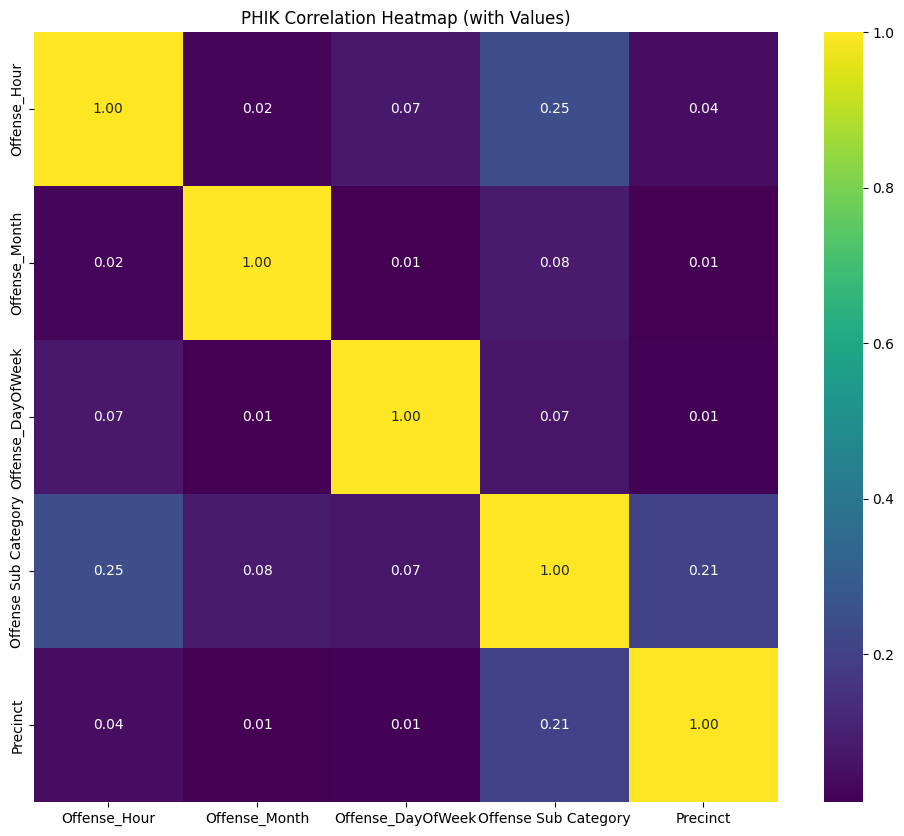

In [ ]:

import phik
from phik.report import plot_correlation_matrix
cols_of_interest = [
    'Offense_Hour',
    'Offense_Month',
    'Offense_DayOfWeek',
    'Offense Sub Category',
    'Precinct'
]

df_corr = crime_data[cols_of_interest].copy()

# Calculate PHIK matrix
phik_matrix = df_corr.phik_matrix(interval_cols=['Offense_Hour', 'Offense_Month'])

plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, cmap='viridis', annot=True, fmt=".2f")  # <-- show numbers
plt.title("PHIK Correlation Heatmap (with Values)")
plt.savefig("phik_heatmap_with_numbers.png", dpi=300, bbox_inches='tight')
plt.show()
